In [10]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf

print("كل شيء جاهز! 🎯")


كل شيء جاهز! 🎯


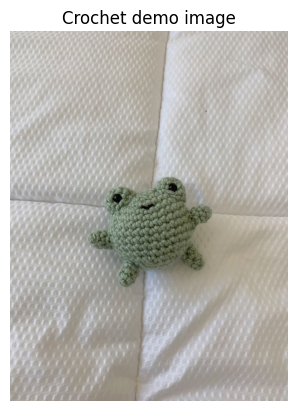

In [16]:
import matplotlib.pyplot as plt
import cv2

# تحميل وعرض صورة تجريبية
img = cv2.imread('/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Crochet demo image")
plt.axis('off')
plt.show()


In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(224, 224)):
    """
    تحميل الصورة، تغيير حجمها وتطبيعها
    """
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # تطبيع القيم بين 0 و1
    return img_array

# تجربة الدالة:
processed_img = preprocess_image('/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg')
print("Image shape after preparation:", processed_img.shape)


Image shape after preparation: (224, 224, 3)


In [20]:
import numpy as np

processed_img = np.expand_dims(processed_img, axis=0)  # يصبح الشكل (1, 224, 224, 3)
print("شكل الصورة بعد إضافة بُعد الدفعة:", processed_img.shape)


شكل الصورة بعد إضافة بُعد الدفعة: (1, 224, 224, 3)


In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# تحميل نموذج VGG16 بدون الطبقات العلوية (Fully Connected Layers)
model = VGG16(weights="imagenet", include_top=False)

# إعادة تحضير الصورة بحيث تكون مناسبة لنموذج VGG16
def preprocess_for_vgg(image_path):
    img_array = preprocess_image(image_path)  # استخدام الدالة التي كتبناها مسبقًا
    img_array = np.expand_dims(img_array, axis=0)  # إضافة البُعد المناسب للنموذج
    img_array = preprocess_input(img_array)  # تطبيق التطبيع الخاص بـ VGG16
    return img_array

# تحضير الصورة
img_ready = preprocess_for_vgg("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg")

# استخراج الميزات
features = model.predict(img_ready)

print("📊 شكل الميزات المستخرجة:", features.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
📊 شكل الميزات المستخرجة: (1, 7, 7, 512)


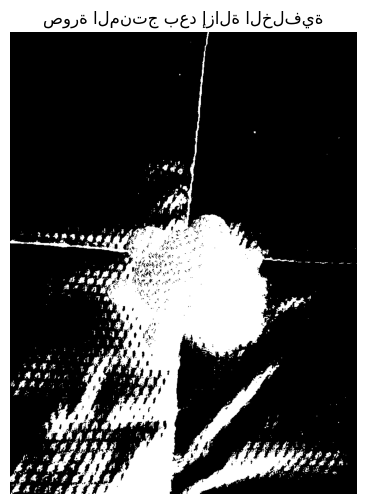

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background(image_path):
    """
    استخدام Otsu's Thresholding لفصل المنتج عن الخلفية
    """
    # تحميل الصورة بالألوان
    img = cv2.imread(image_path)

    # تحويل الصورة إلى تدرجات الرمادي
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # تطبيق Thresholding باستخدام Otsu
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # إظهار الصورة بعد المعالجة
    plt.figure(figsize=(6, 6))
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")
    plt.title("صورة المنتج بعد إزالة الخلفية")
    plt.show()

    return thresh

# تطبيق المعالجة على الصورة
processed_image = remove_background("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg")


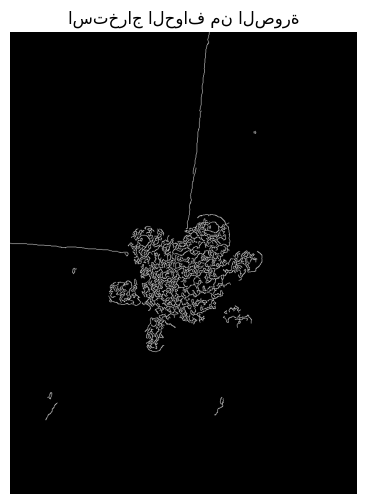

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_edges(image_path):
    """
    تحميل الصورة وتحليلها لاستخراج الحواف باستخدام Canny Edge Detection
    """
    # تحميل الصورة وتحويلها إلى تدرج رمادي
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # تطبيق فلتر التمويه لتقليل الضوضاء
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    
    # استخراج الحواف باستخدام Canny
    edges = cv2.Canny(img_blur, threshold1=50, threshold2=150)
    
    # عرض النتيجة
    plt.figure(figsize=(6, 6))
    plt.imshow(edges, cmap="gray")
    plt.axis("off")
    plt.title("استخراج الحواف من الصورة")
    plt.show()

    return edges

# تجربة استخراج الحواف على الصورة
edges = extract_edges("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg")


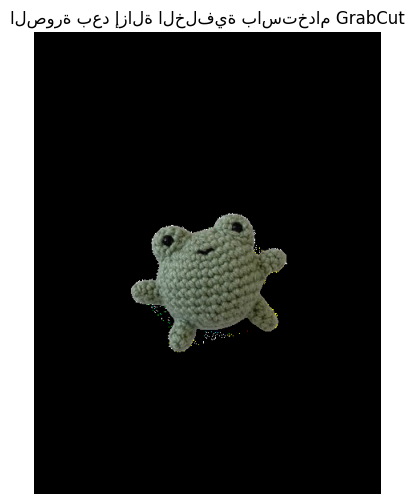

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background_grabcut(image_path):
    """
    استخدام GrabCut لإزالة الخلفية والحصول على المنتج فقط
    """
    # تحميل الصورة
    img = cv2.imread(image_path)
    mask = np.zeros(img.shape[:2], np.uint8)

    # إنشاء مصفوفات مؤقتة لخوارزمية GrabCut
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # تحديد المستطيل الأولي حول المنتج
    height, width = img.shape[:2]
    rect = (10, 10, width - 20, height - 20)  # ترك بعض الحواف

    # تطبيق GrabCut
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # تحديد القناع النهائي
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # تطبيق القناع على الصورة الأصلية
    img_result = img * mask2[:, :, np.newaxis]

    # عرض الصورة بعد إزالة الخلفية
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("الصورة بعد إزالة الخلفية باستخدام GrabCut")
    plt.show()

    return img_result

# تجربة إزالة الخلفية على الصورة الأصلية
processed_image = remove_background_grabcut("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd-removebg-preview.png")


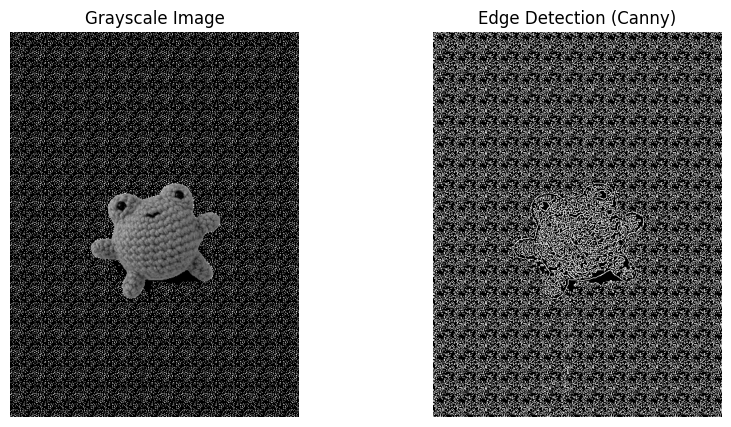

True

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحميل الصورة بعد إزالة الخلفية
image_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd-removebg-preview.png"  # قم بتعديل المسار حسب موقع الصورة
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# تطبيق كشف الحواف باستخدام Canny
edges = cv2.Canny(image, 50, 150)

# عرض الصورة الأصلية والحواف المستخرجة
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.axis("off")

plt.show()

# حفظ النتيجة
cv2.imwrite("crochet_edges.png", edges)


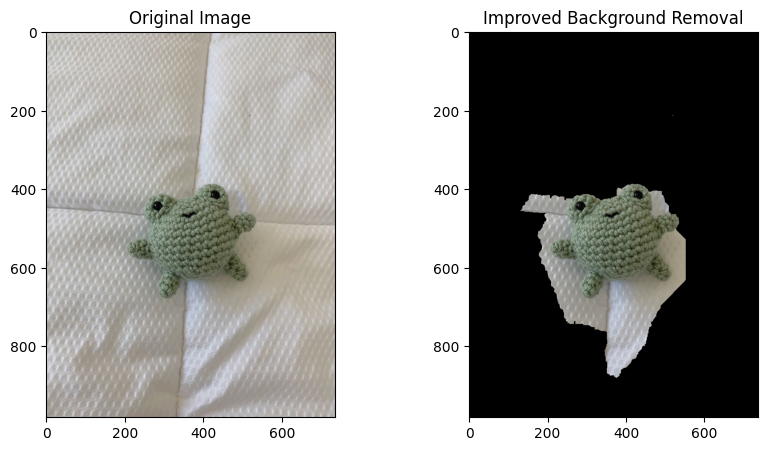

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحميل الصورة
image = cv2.imread("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg")  # استبدل باسم ملفك
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # تحويل الألوان إلى RGB

# تحديد منطقة الاهتمام (ROI) يدويًا
h, w = image.shape[:2]
rect = (50, 50, w-100, h-100)  # تحديد مستطيل حول الجسم

# إنشاء أقنعة GrabCut
mask = np.zeros(image.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# تطبيق GrabCut
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# إنشاء قناع جديد حيث يكون المنتج فقط ظاهرًا
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
result = image * mask2[:, :, np.newaxis]

# عرض النتائج
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(image), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(result), plt.title("Improved Background Removal")
plt.show()


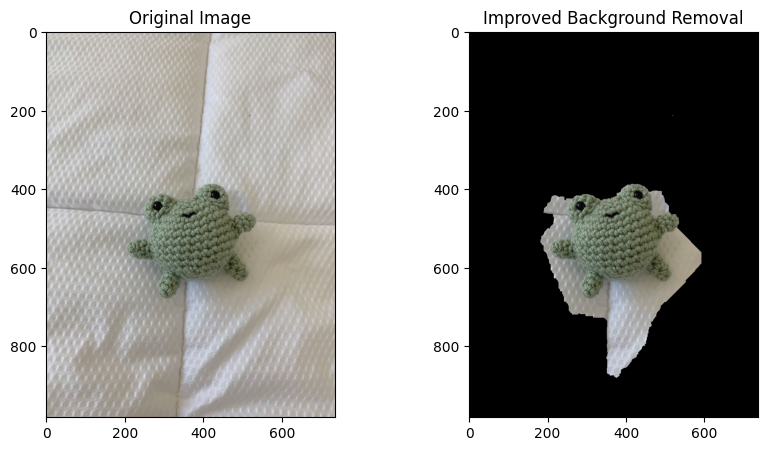

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحميل الصورة
image = cv2.imread("/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg")  # استبدل باسم ملفك
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# تحديد المنطقة المرغوبة يدويًا
mask = np.zeros(image.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# تحديد مستطيل حول المنتج فقط
h, w = image.shape[:2]
rect = (50, 50, w-100, h-100)

# تطبيق GrabCut
cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# تحسين القناع عبر إزالة الخلفية المتبقية
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
result = image * mask2[:, :, np.newaxis]

# عرض الصورة النهائية
plt.figure(figsize=(10,5))
plt.subplot(1,2,1), plt.imshow(image), plt.title("Original Image")
plt.subplot(1,2,2), plt.imshow(result), plt.title("Improved Background Removal")
plt.show()


In [59]:
!pip install rembg


  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached scikit_image-0.25.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached tifffile-2025.1.10-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 685.1 kB/s eta 0:00:000:00:01
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 1.8 MB/s eta 0:00:0000:0100:01
Using cached scikit_image-0.25.1-cp312-cp312-macosx_12

In [65]:
from rembg import remove
from PIL import Image
import io

# تحميل الصورة
input_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ضع اسم الصورة لديك
output_path = "crochet_no_bg.png"

# فتح الصورة
with open(input_path, "rb") as inp_file:
    input_image = inp_file.read()

# إزالة الخلفية
output_image = remove(input_image)

# حفظ الصورة الناتجة
with open(output_path, "wb") as out_file:
    out_file.write(output_image)

# عرض الصورة
img = Image.open(output_path)
img.show()


ModuleNotFoundError: No module named 'onnxruntime'

In [67]:
!pip install onnxruntime


  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.2 MB/s eta 0:00:00
Using cached sympy-1.13.3-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00-:--:--
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from rembg import remove
from PIL import Image
import io

# تحميل الصورة
input_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ضع اسم الصورة لديك
output_path = "crochet_no_bg.png"

# فتح الصورة
with open(input_path, "rb") as inp_file:
    input_image = inp_file.read()

# إزالة الخلفية
output_image = remove(input_image)

# حفظ الصورة الناتجة
with open(output_path, "wb") as out_file:
    out_file.write(output_image)

# عرض الصورة
img = Image.open(output_path)
img.show()


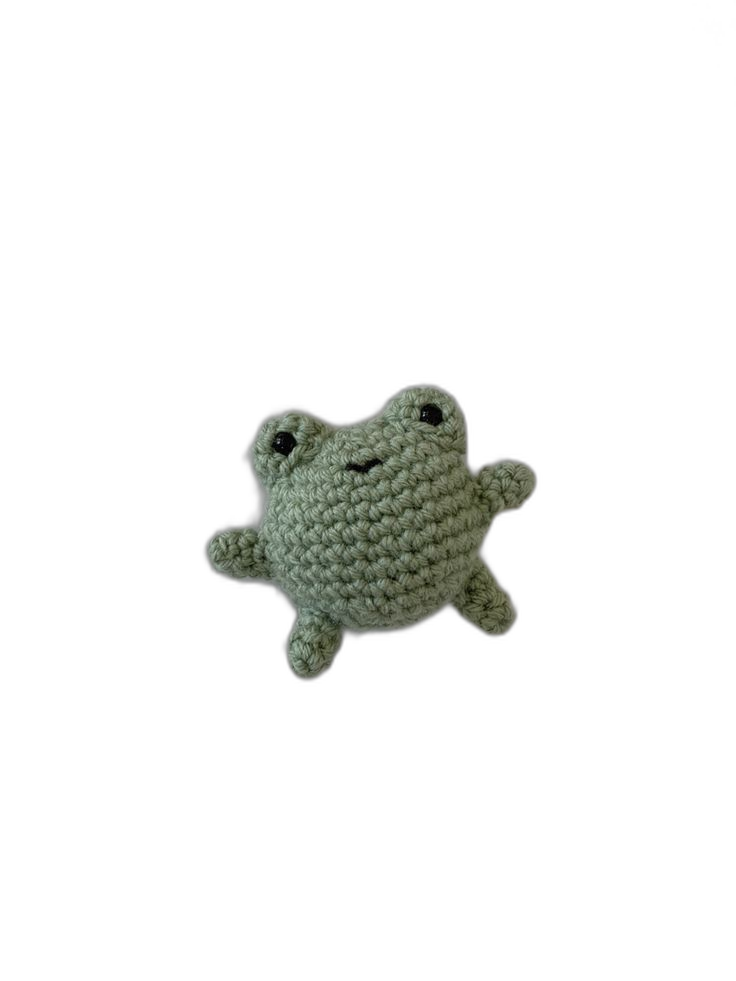

In [6]:
from rembg import remove
from PIL import Image
import io
import IPython.display as display

# تحميل الصورة الأصلية
input_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ضع اسم الصورة لديك
image = Image.open(input_path)

# إزالة الخلفية
output_image = remove(image)

# عرض الصورة داخل Jupyter Notebook
display.display(output_image)


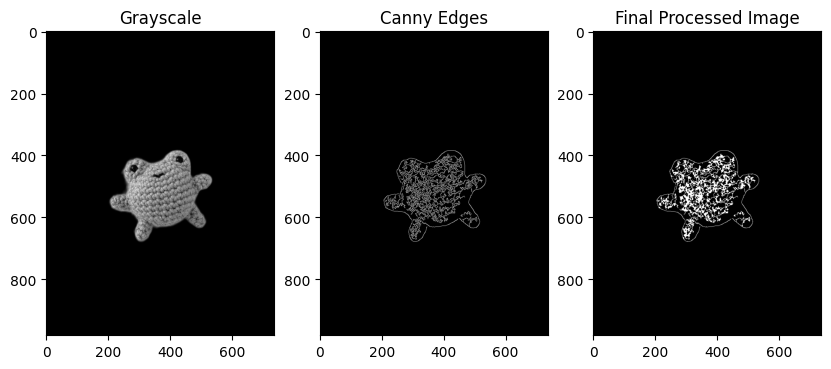

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image

# تحميل الصورة الأصلية
input_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ضع اسم الصورة لديك
image = Image.open(input_path)

# إزالة الخلفية
removed_bg = remove(image)

# تحويل الصورة إلى مصفوفة NumPy
image_np = np.array(removed_bg)

# تحويل الصورة إلى تدرجات الرمادي
gray = cv2.cvtColor(image_np, cv2.COLOR_RGBA2GRAY)

# تطبيق Gaussian Blur لتنعيم الحواف
blurred = cv2.GaussianBlur(gray, (5,5), 0)

# تطبيق Canny Edge Detection
edges = cv2.Canny(blurred, 50, 150)

# تطبيق Morphological Operations لتحسين الحدود
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)

# عرض النتائج
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")

plt.subplot(1,3,2)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edges")

plt.subplot(1,3,3)
plt.imshow(eroded, cmap='gray')
plt.title("Final Processed Image")

plt.show()


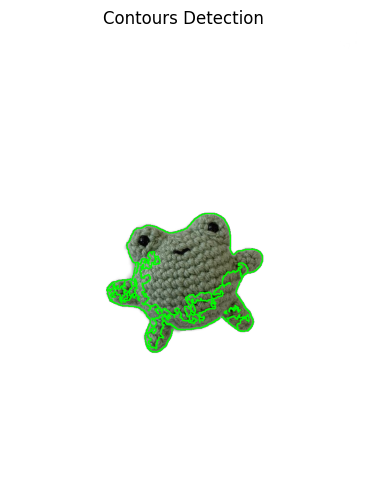

In [10]:
# البحث عن الحدود (Contours)
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# رسم الحدود على الصورة الأصلية
contour_img = image_np.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0,255), 2)  # رسم باللون الأخضر

# عرض الصورة مع الحدود
plt.figure(figsize=(6,6))
plt.imshow(contour_img)
plt.title("Contours Detection")
plt.axis("off")
plt.show()


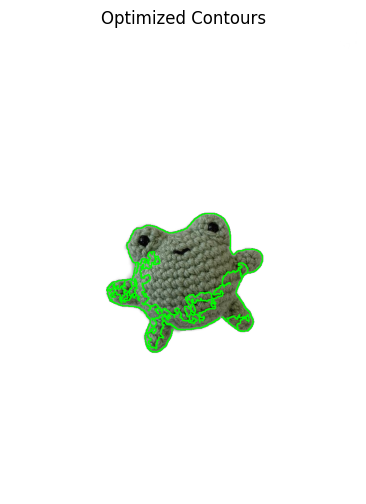

In [12]:
# البحث عن الحدود
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تصفية الحدود الصغيرة بناءً على المساحة
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

# رسم الحدود المحسنة على الصورة الأصلية
contour_img_filtered = image_np.copy()
cv2.drawContours(contour_img_filtered, filtered_contours, -1, (0,255,0,255), 2)  # باللون الأخضر

# عرض الصورة المحسنة
plt.figure(figsize=(6,6))
plt.imshow(contour_img_filtered)
plt.title("Optimized Contours")
plt.axis("off")
plt.show()


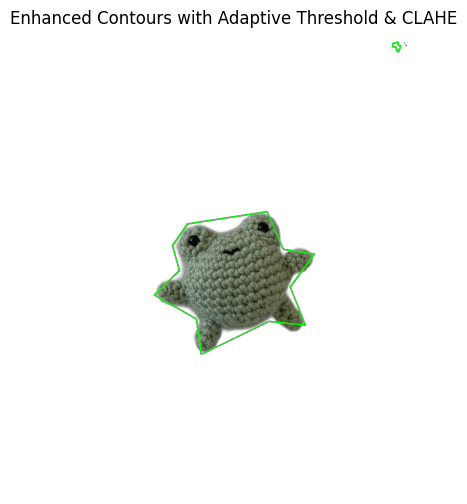

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحويل الصورة إلى التدرج الرمادي
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# تحسين التباين باستخدام CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

# تطبيق Adaptive Threshold بدلاً من Canny
thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# تطبيق العمليات المورفولوجية لتحسين الشكل العام للحواف
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# العثور على الحدود الخارجية
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تبسيط الحدود باستخدام ApproxPolyDP
simplified_contours = [cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True) for cnt in contours]

# رسم الحدود على الصورة الأصلية
contour_img_filtered = image_np.copy()
cv2.drawContours(contour_img_filtered, simplified_contours, -1, (0,255,0,255), 2)

# عرض النتائج
plt.figure(figsize=(6,6))
plt.imshow(contour_img_filtered)
plt.title("Enhanced Contours with Adaptive Threshold & CLAHE")
plt.axis("off")
plt.show()


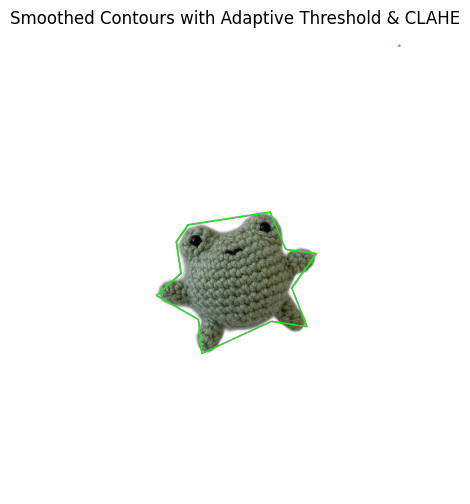

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحويل الصورة إلى التدرج الرمادي
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# تحسين التباين باستخدام CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

# تطبيق GaussianBlur لتنعيم الصورة وتقليل الزوايا الحادة
blurred = cv2.GaussianBlur(enhanced, (5,5), 0)

# تطبيق Adaptive Threshold بدلاً من Canny
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# تطبيق العمليات المورفولوجية لتحسين الشكل العام للحواف
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# العثور على الحدود الخارجية
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تبسيط الحدود مع حساسية أقل لجعلها أكثر سلاسة
simplified_contours = [cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True) for cnt in contours]

# رسم الحدود على الصورة الأصلية
contour_img_filtered = image_np.copy()
cv2.drawContours(contour_img_filtered, simplified_contours, -1, (0,255,0,255), 2)

# عرض النتائج
plt.figure(figsize=(6,6))
plt.imshow(contour_img_filtered)
plt.title("Smoothed Contours with Adaptive Threshold & CLAHE")
plt.axis("off")
plt.show()


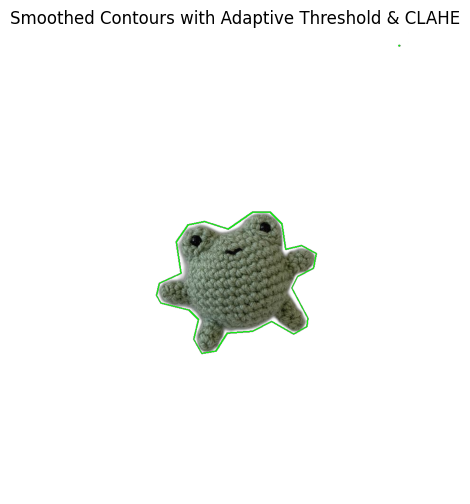

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحويل الصورة إلى التدرج الرمادي
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# تحسين التباين باستخدام CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

# تطبيق GaussianBlur لتنعيم الصورة وتقليل الزوايا الحادة
blurred = cv2.GaussianBlur(enhanced, (5,5), 0)

# تطبيق Adaptive Threshold بدلاً من Canny
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# تطبيق العمليات المورفولوجية لتحسين الشكل العام للحواف
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# العثور على الحدود الخارجية
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تبسيط الحدود مع حساسية أقل لجعلها أكثر سلاسة
simplified_contours = [cv2.approxPolyDP(cnt, 0.005 * cv2.arcLength(cnt, True), True) for cnt in contours]

# رسم الحدود على الصورة الأصلية
contour_img_filtered = image_np.copy()
cv2.drawContours(contour_img_filtered, simplified_contours, -1, (0,255,0,255), 2)

# عرض النتائج
plt.figure(figsize=(6,6))
plt.imshow(contour_img_filtered)
plt.title("Smoothed Contours with Adaptive Threshold & CLAHE")
plt.axis("off")
plt.show()


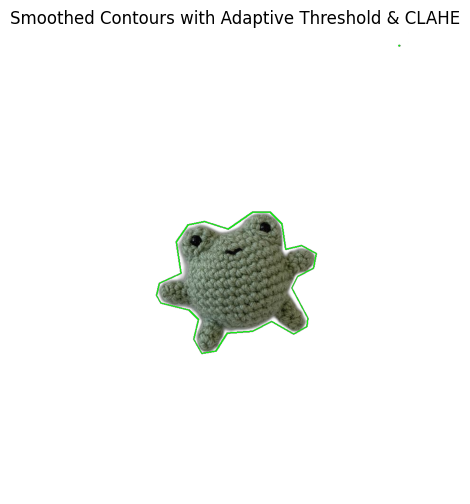

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# تحويل الصورة إلى التدرج الرمادي
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# تحسين التباين باستخدام CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

# تطبيق GaussianBlur لتنعيم الصورة وتقليل الزوايا الحادة
blurred = cv2.GaussianBlur(enhanced, (5,5), 0)

# تطبيق Adaptive Threshold بدلاً من Canny
edges = cv2.Canny(gray, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تطبيق العمليات المورفولوجية لتحسين الشكل العام للحواف
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# العثور على الحدود الخارجية
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# تبسيط الحدود مع حساسية أقل لجعلها أكثر سلاسة
edges = cv2.Canny(gray, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# رسم الحدود على الصورة الأصلية
contour_img_filtered = image_np.copy()
cv2.drawContours(contour_img_filtered, simplified_contours, -1, (0,255,0,255), 2)

# عرض النتائج
plt.figure(figsize=(6,6))
plt.imshow(contour_img_filtered)
plt.title("Smoothed Contours with Adaptive Threshold & CLAHE")
plt.axis("off")
plt.show()


In [6]:
import openai
import base64

# 🔹 ضع مفتاح API الخاص بك هنا
client = openai.OpenAI("api_key")

# 🔹 تحميل الصورة وتحويلها إلى Base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# 🔹 تحديد مسار الصورة
image_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ✨ ضع المسار الصحيح للصورة

# 🔹 إرسال الصورة إلى OpenAI لتحليلها
def analyze_image(image_path):
    image_base64 = encode_image(image_path)

    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {"role": "system", "content": "أنت مساعد خبير في تحليل صور الكروشيه وإنشاء باترون."},
            {"role": "user", "content": [
                {"type": "text", "text": "هذه صورة كروشيه، حللها واستخرج لي الباترون."},
                {"type": "image", "image": image_base64}
            ]}
        ],
        max_tokens=1000
    )

    return response.choices[0].message.content

# 🔹 تشغيل التحليل وعرض النتائج
pattern = analyze_image(image_path)
print("📌 الباترون المستخرج:\n", pattern)


NotFoundError: Error code: 404 - {'error': {'message': 'The model `gpt-4-turbo` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [42]:
!pip install openai



  Using cached openai-1.63.0-py3-none-any.whl.metadata (27 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached jiter-0.8.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.2 kB)
Using cached openai-1.63.0-py3-none-any.whl (472 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached jiter-0.8.2-cp312-cp312-macosx_11_0_arm64.whl (310 kB)

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import openai

client = openai.OpenAI("api")

models = client.models.list()
for model in models:
    print(model.id)


gpt-4o-mini-audio-preview-2024-12-17
dall-e-3
dall-e-2
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview
o1-mini-2024-09-12
o1-preview-2024-09-12
o1-mini
o1-preview
whisper-1
gpt-4o-mini-audio-preview
gpt-4o-2024-11-20
babbage-002
tts-1-hd-1106
gpt-4o-mini-2024-07-18
gpt-4o-mini
tts-1-hd
gpt-4o-2024-08-06
gpt-4o
text-embedding-3-large
tts-1
tts-1-1106
davinci-002
gpt-3.5-turbo-1106
omni-moderation-2024-09-26
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
gpt-3.5-turbo-0125
gpt-3.5-turbo
gpt-3.5-turbo-16k
text-embedding-3-small
gpt-4o-2024-05-13
text-embedding-ada-002
omni-moderation-latest


In [12]:
!pip install google-cloud-vision



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.4/523.4 kB 5.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [20]:
import os
print(os.listdir("/Users/macbook03/"))


['untitled folder', 'python project.py', 'Untitled10.ipynb', '.zshrc.save', 'Untitled7.ipynb', '.eclipse', '.config', 'Untitled34.ipynb', 'Music', 'blurred_image.jpg', '.kaggle', 'edges_image.jpg', '.condarc', 'Untitled36.ipynb', '.docker', 'Untitled12.ipynb', 'Untitled5.ipynb', 'remaproject.ipynb', 'image_upload.ipynb', 'Untitled1.ipynb', 'rema_ai', 'crochet', 'Untitled16.ipynb', '.DS_Store', 'nltk_data', 'Untitled32.ipynb', 'statsfinal.csv', '.CFUserTextEncoding', 'Untitled30.ipynb', '.xonshrc', 'gray_image.jpg', 'Untitled29.ipynb', 'anaconda_projects', 'Untitled3.ipynb', 'Untitled14.ipynb', 'Untitled.ipynb', 'development', 'Untitled37.ipynb', '.zshrc', '.u2net', 'hanoo', 'Untitled4.ipynb', 'Untitled13.ipynb', 'Untitled6.ipynb', 'Pictures', 'Untitled11.ipynb', '.zprofile', 'rema', '.dartServer', '.nvm', 'Untitled35.ipynb', '.pub-cache', 'r', 'Untitled31.ipynb', 'Untitled15.ipynb', 'political_social_media.csv', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'Desktop', 'Library', 'html

In [22]:
import os

# تحديد المسار إلى ملف JSON
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/macbook03/inbound-source-451207-i4-6f10bc9ace5e.json"

# التأكد من أن المتغير قد تم تعيينه بشكل صحيح
print("Google API Key Set:", os.environ.get("GOOGLE_APPLICATION_CREDENTIALS"))


Google API Key Set: /Users/macbook03/inbound-source-451207-i4-6f10bc9ace5e.json


In [50]:
import openai
import base64
from google.cloud import vision
from google.oauth2 import service_account

# 🔹 تحميل مفتاح Google Cloud Vision API
GOOGLE_CLOUD_KEY_PATH = "/Users/macbook03/inbound-source-451207-i4-6f10bc9ace5e.json"  # ضع مسار مفتاح الخدمة هنا
credentials = service_account.Credentials.from_service_account_file(GOOGLE_CLOUD_KEY_PATH)
client = vision.ImageAnnotatorClient(credentials=credentials)

# 🔹 تحليل الصورة باستخدام Google Cloud Vision API
def analyze_image_google(image_path):
    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.label_detection(image=image)
    labels = [label.description for label in response.label_annotations]

    response = client.object_localization(image=image)
    objects = [obj.name for obj in response.localized_object_annotations]

    response = client.text_detection(image=image)
    texts = [text.description for text in response.text_annotations]

    return {"labels": labels, "objects": objects, "texts": texts}

# 🔹 تحميل مفتاح OpenAI API
openai.api_key = "your-openai-api-key"  # استبدله بمفتاحك الفعلي

# 🔹 إرسال البيانات إلى GPT-4o لإنشاء باترون كروشيه
def generate_crochet_pattern(analysis_data):
    prompt = f"""
    أنت خبير في الكروشيه. استنادًا إلى وصف الصورة التالي، قم بإنشاء باترون كروشيه:
    - العلامات: {', '.join(analysis_data['labels'])}
    - الأشياء المكتشفة: {', '.join(analysis_data['objects'])}
    - النصوص الموجودة: {', '.join(analysis_data['texts'])}

    قم بإنشاء تعليمات باترون كروشيه بناءً على هذه البيانات.
    """

    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "أنت خبير في الكروشيه."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=500
    )

    return response["choices"][0]["message"]["content"]

# 🔹 تجربة التحليل والتوليد
image_path = "/Users/macbook03/Downloads/650aa89f941480b0fa90449fb45a49cd.jpg"  # ضع اسم الصورة لديك
analysis_data = analyze_image_google(image_path)
pattern = generate_crochet_pattern(analysis_data)

print("📌 الباترون المستخرج:\n", pattern)


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #806522869388 by visiting https://console.developers.google.com/billing/enable?project=806522869388 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry. [reason: "BILLING_DISABLED"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "vision.googleapis.com"
}
metadata {
  key: "containerInfo"
  value: "806522869388"
}
metadata {
  key: "consumer"
  value: "projects/806522869388"
}
, locale: "en-US"
message: "This API method requires billing to be enabled. Please enable billing on project #806522869388 by visiting https://console.developers.google.com/billing/enable?project=806522869388 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry."
, links {
  description: "Google developers console billing"
  url: "https://console.developers.google.com/billing/enable?project=806522869388"
}
]

In [30]:
!pip install opencv-python



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [54]:
!pip install flask opencv-python pillow numpy



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
